
# Metrics

## Data

### Close value

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

adobe = pd.read_csv("../dane/adobe.csv")
time_series_start = 0
time_series_end = 300

def create_series(column_name):
    global time_series_start, time_series_end
    series = pd.Series(list(adobe[column_name]), index=adobe["date"])
    return series[time_series_start:time_series_end]


adobe_close = create_series("close")
print(type(adobe_close))

<class 'pandas.core.series.Series'>


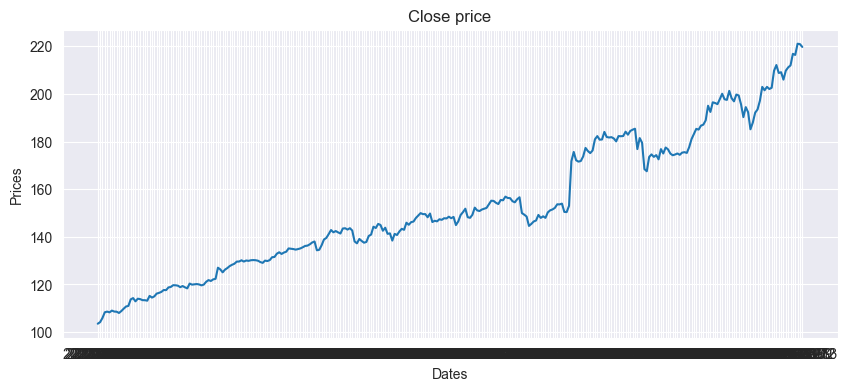

In [4]:
def plot(data):
    plt.figure(figsize=(10,4))
    #plt.plot([x for x in adobe["date"] if x % 20 == 0], [y for y in adobe["close"] if y % 20 == 0])
    plt.plot(data)
    plt.title("Close price")
    plt.xlabel("Dates")
    plt.ylabel("Prices")

plot(adobe_close)

### Other values

In [5]:
adobe_series = {"open": create_series("open"), "close": create_series("close"),
                "adj_close": create_series("adjclose"), "high": create_series("high"),
                "low": create_series("low"), "volume": create_series("volume")}

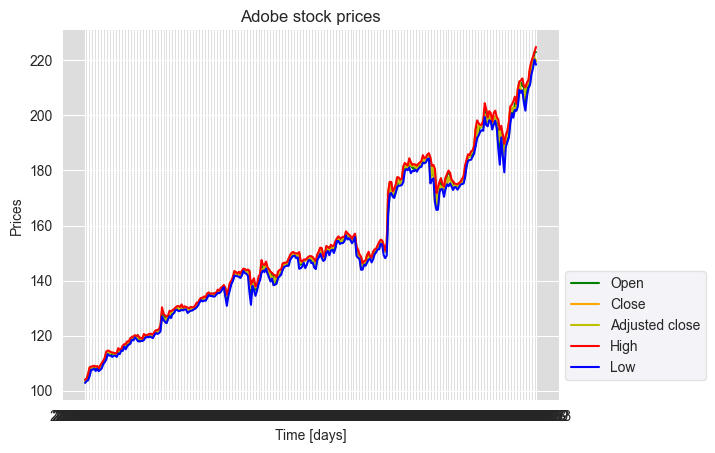

In [6]:
fig = plt.figure(facecolor="w")
ax = fig.add_subplot(111, facecolor="#dddddd", axisbelow=True)
ax.plot(adobe_series["open"], "g", markersize=2,  label="Open")
ax.plot(adobe_series["close"], "orange", markersize=2,  label="Close")
ax.plot(adobe_series["adj_close"], "y", markersize=2,  label="Adjusted close")
ax.plot(adobe_series["high"], "r", markersize=2,  label="High")
ax.plot(adobe_series["low"], "b", markersize=2,  label="Low")
ax.set_title("Adobe stock prices")
ax.set_xlabel("Time [days]")
ax.set_ylabel("Prices")
legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.2))
legend.get_frame().set_alpha(0.5)
for spine in ("top", "right", "bottom", "left"):
    ax.spines[spine].set_visible(False)
plt.show()

## Correctness metric

### Add noise

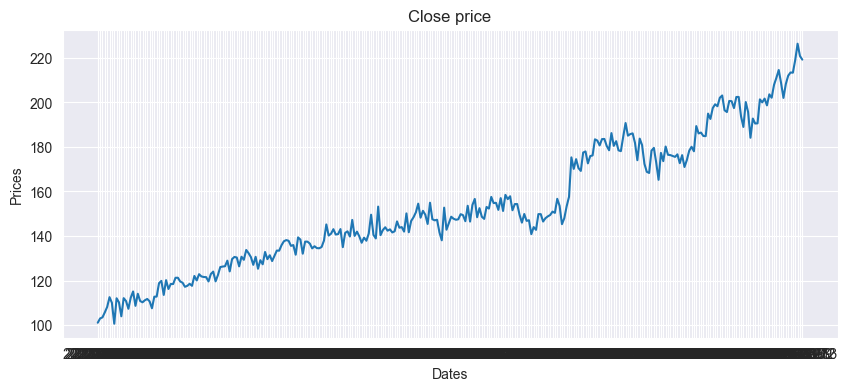

In [7]:
import numpy as np

def add_noise(data):
    global time_series_start, time_series_end
    mean = 0
    std_dev = 3
    noise = np.random.normal(mean, std_dev, time_series_end-time_series_start)
    return data + noise

adobe_closed_noised = add_noise(adobe_close)
plot(adobe_closed_noised)

### Heinrich's correctness metric on values

In [8]:
def d(w_i, w_r, alpha):
    return pow(abs(w_i - w_r) / max(abs(w_i), abs(w_r)), alpha)

def heinrich_values(w_i, w_r, alpha):
    return 1 - d(w_i, w_r, alpha)

def draw_heinrich_quality(sensitive, medium, insensitive, level):
    fig = plt.figure(facecolor="w")
    ax = fig.add_subplot(111, facecolor="#dddddd", axisbelow=True)
    ax.plot(sensitive, "b", lw=1, label="Sensitive: alpha=0.1")
    ax.plot(medium, "r", lw=1, label="Medium sensitivity: alpha=0.3")
    ax.plot(insensitive, "g", lw=1, label="Insensitive: alpha=1")
    ax.set_title(f"Heinrich quality metric [{level} level]")
    ax.set_xlabel("Time [days]")
    ax.set_ylabel("Quality")
    legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.2))
    legend.get_frame().set_alpha(0.5)
    for spine in ("top", "right", "bottom", "left"):
        ax.spines[spine].set_visible(False)
    plt.show()

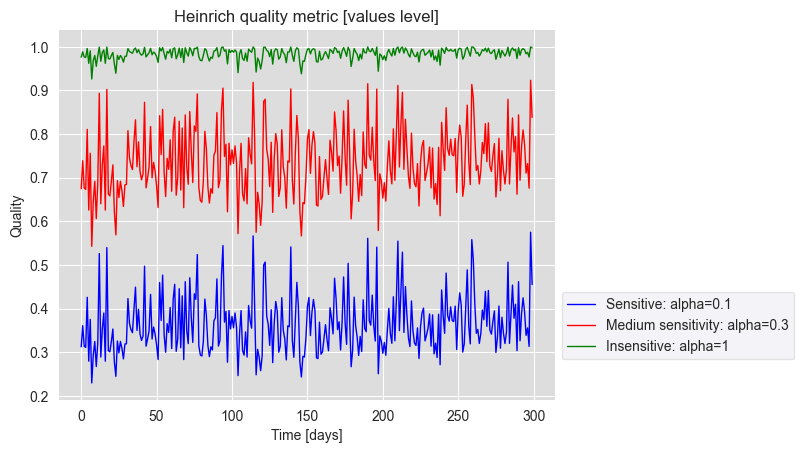

In [9]:
qualities_sensitive = []
qualities_medium = []
qualities_insensitive = []
for i in range(time_series_start, time_series_end):
    qualities_sensitive.append(heinrich_values(adobe_closed_noised[i], adobe_close[i], 0.1))
    qualities_medium.append(heinrich_values(adobe_closed_noised[i], adobe_close[i], 0.3))
    qualities_insensitive.append(heinrich_values(adobe_closed_noised[i], adobe_close[i], 1))

draw_heinrich_quality(qualities_sensitive, qualities_medium, qualities_insensitive, "values")

### Heinrich's correctness metric on tuples

In [10]:
def heinrich_tuples(t: list, e: list, g: list, alpha: float = 1):
    quality_sum = 0
    for i in range(len(t)):
        quality_sum += heinrich_values(t[i], e[i], alpha) * g[i]
    return quality_sum / sum(g)

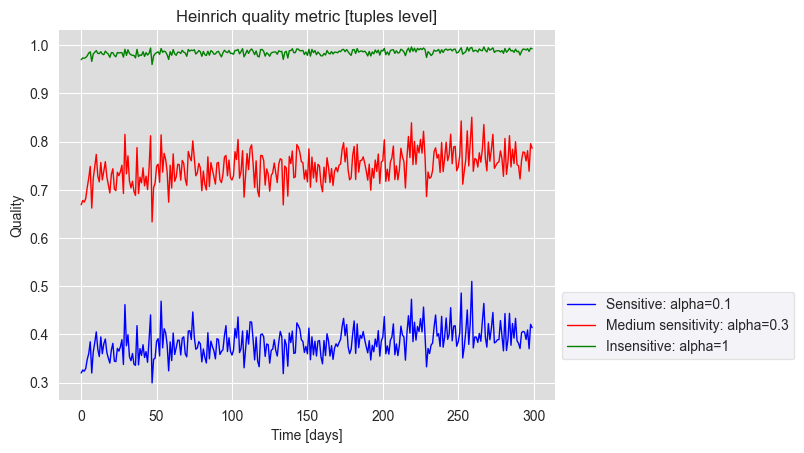

In [11]:
adobe_series_noised = {"open": add_noise(adobe_series["open"]), "close": add_noise(adobe_series["close"]),
                       "adj_close": add_noise(adobe_series["adj_close"]), "high": add_noise(adobe_series["high"]),
                       "low": add_noise(adobe_series["low"]), "volume": add_noise(adobe_series["volume"])}
adobe_tuple_weights = [0.2, 0.2, 0.25, 0.15, 0.15, 0.05]

qualities_sensitive = []
qualities_medium = []
qualities_insensitive = []
for i in range(time_series_start, time_series_end):
    adobe_tuple = [adobe_series["open"][i], adobe_series["close"][i], adobe_series["adj_close"][i],
                   adobe_series["high"][i], adobe_series["low"][i], adobe_series["volume"][i]]
    adobe_tuple_noised = [adobe_series_noised["open"][i], adobe_series_noised["close"][i],
                          adobe_series_noised["adj_close"][i], adobe_series_noised["high"][i],
                          adobe_series_noised["low"][i], adobe_series_noised["volume"][i]]

    qualities_sensitive.append(heinrich_tuples(adobe_tuple_noised, adobe_tuple, adobe_tuple_weights, 0.1))
    qualities_medium.append(heinrich_tuples(adobe_tuple_noised, adobe_tuple, adobe_tuple_weights, 0.3))
    qualities_insensitive.append(heinrich_tuples(adobe_tuple_noised, adobe_tuple, adobe_tuple_weights, 1))

draw_heinrich_quality(qualities_sensitive, qualities_medium, qualities_insensitive, "tuples")

### Heinrich's correctness metric on relation

In [12]:
def heinrich_relation(R: list, E: list, alpha: float = 1):
    quality_sum = 0
    for i in range(len(R)):
        quality_sum += heinrich_tuples(R[i], E[i], adobe_tuple_weights, alpha)
    return quality_sum / len(R)

In [13]:
adobe_tuples = []
adobe_tuples_noised = []

for i in range(time_series_start, time_series_end):
    adobe_tuples.append([adobe_series["open"][i], adobe_series["close"][i], adobe_series["adj_close"][i],
                   adobe_series["high"][i], adobe_series["low"][i], adobe_series["volume"][i]])
    adobe_tuples_noised.append([adobe_series_noised["open"][i], adobe_series_noised["close"][i],
                          adobe_series_noised["adj_close"][i], adobe_series_noised["high"][i],
                          adobe_series_noised["low"][i], adobe_series_noised["volume"][i]])

print(f"Quality (sensitive): {heinrich_relation(adobe_tuples_noised, adobe_tuples, 0.1)}")
print(f"Quality (medium sensitiveness): {heinrich_relation(adobe_tuples_noised, adobe_tuples, 0.3)}")
print(f"Quality (insensitive): {heinrich_relation(adobe_tuples_noised, adobe_tuples, 1.0)}")

Quality (sensitive): 0.38455922734809056
Quality (medium sensitiveness): 0.7479682536309579
Quality (insensitive): 0.9853658761469591


## Completeness metrics

### Add incompleteness

In [14]:
def add_incompleteness(data):
    incompleteness = np.random.choice([0, 1], time_series_end-time_series_start, p=[0.1, 0.9])
    adobe_close_incomplete = []
    for i in range(time_series_start, time_series_end):
        if incompleteness[i] == 1:
            adobe_close_incomplete.append(data[i])
        else:
            adobe_close_incomplete.append(0.0)
    return adobe_close_incomplete

def draw_blake(data, title, y_label):
    fig = plt.figure(facecolor="w")
    ax = fig.add_subplot(111, facecolor="#dddddd", axisbelow=True)
    ax.plot(data, "o", markersize=2,  label="Incompleteness probability: 0.1")
    ax.set_title(title)
    ax.set_xlabel("Time [days]")
    ax.set_ylabel(y_label)
    legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.2))
    legend.get_frame().set_alpha(0.5)
    for spine in ("top", "right", "bottom", "left"):
        ax.spines[spine].set_visible(False)
    plt.show()

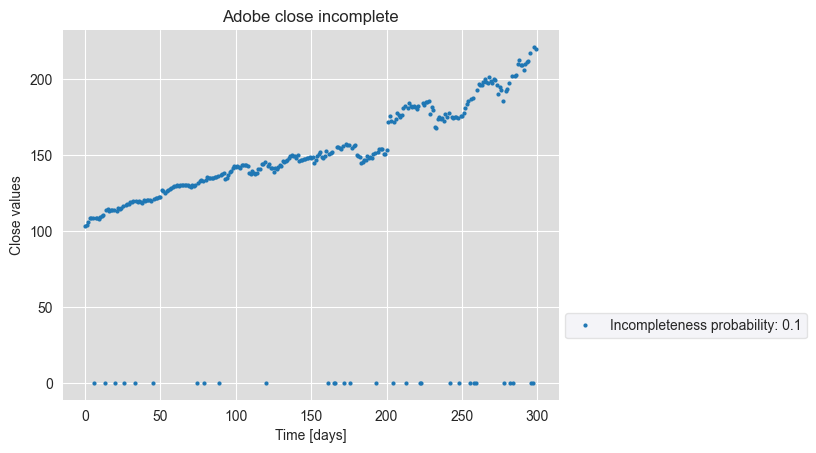

In [15]:
adobe_close_incomplete = add_incompleteness(adobe_close)
draw_blake(adobe_close_incomplete, "Adobe close incomplete", "Close values")

### Blake's completeness metric on values

In [16]:
def blake_values(value):
    return 1.0 if value != 0.0 else 0.0

In [17]:
qualities = []
for i in range(time_series_end - time_series_start):
    qualities.append(blake_values(adobe_close_incomplete[i]))

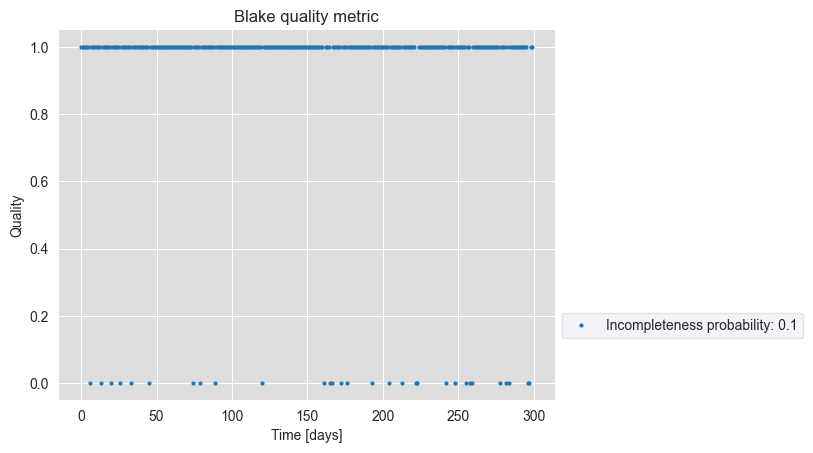

In [18]:
draw_blake(qualities, "Blake quality metric", "Quality")

### Blake's completeness metric on tuples

In [19]:
import math

def blake_tuples(values: list):
    return not(any(math.isclose(i, 0.0) for i in values))

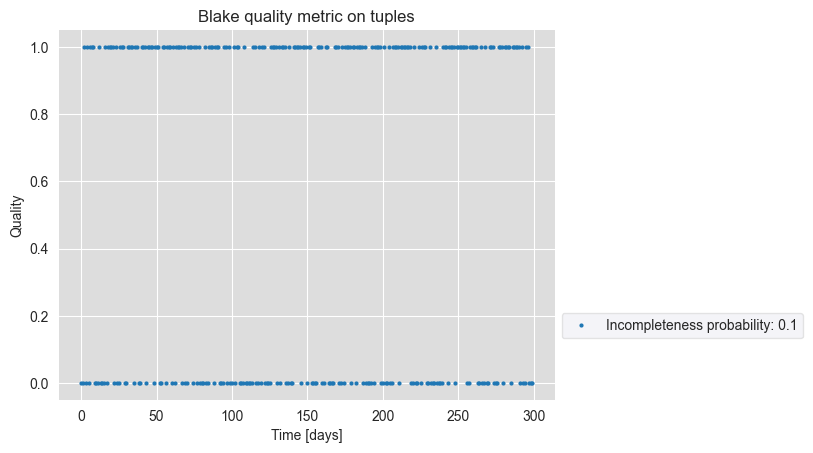

In [20]:
qualities = []
adobe_series_incomplete = {"open": add_incompleteness(adobe_series["open"]), "close": add_incompleteness(adobe_series["close"]),
                       "adj_close": add_incompleteness(adobe_series["adj_close"]), "high": add_incompleteness(adobe_series["high"]),
                       "low": add_incompleteness(adobe_series["low"]), "volume": add_incompleteness(adobe_series["volume"])}

for i in range(time_series_end - time_series_start):
    adobe_tuples_incomplete = [adobe_series_incomplete["open"][i], adobe_series_incomplete["close"][i],
                               adobe_series_incomplete["adj_close"][i], adobe_series_incomplete["high"][i],
                               adobe_series_incomplete["low"][i], adobe_series_incomplete["volume"][i]]
    qualities.append(blake_tuples(adobe_tuples_incomplete))

draw_blake(qualities, "Blake quality metric on tuples", "Quality")

### Blake's completeness metric on relation

In [21]:
def blake_relation(relation: list):
    number_of_zero_tuples = 0
    for i in relation:
        if not blake_tuples(i):
            number_of_zero_tuples += 1
    return 1 - number_of_zero_tuples / len(relation)

In [22]:
adobe_tuples_incomplete = []
for i in range(time_series_end - time_series_start):
    adobe_tuples_incomplete.append([adobe_series_incomplete["open"][i], adobe_series_incomplete["close"][i],
                                    adobe_series_incomplete["adj_close"][i], adobe_series_incomplete["high"][i],
                                    adobe_series_incomplete["low"][i], adobe_series_incomplete["volume"][i]])

print(f"Blake's quality: {blake_relation(adobe_tuples_incomplete)}")

Blake's quality: 0.5666666666666667
